In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
import scipy as sp

import functions.data_wrangling as dw
import functions.eddy_feedback as ef

In [2]:
def bootstrap_resampling_pamip(ds, num_samples=1000):
    
    
    bootstrap_indices = np.random.choice(ds.sizes["time"], size=(num_samples, ds.sizes["time"]), replace=True)
    bootstrap_dssets = [ds.isel(time=idx) for idx in bootstrap_indices]
    
    return bootstrap_dssets

# Check Data

## Import data

In [3]:
pamip_path = '/home/links/ct715/data_storage/PAMIP/processed_monthly/daily-efp_mon_u_divFy_psl'
models = sorted(os.path.basename(model).split('_')[0] for model in os.listdir(pamip_path) if model.endswith('.nc'))


# Create dictionary containing each model name and dataset
djf = {}
jas = {}
for model in models:
    file_path = os.path.join(pamip_path, f'{model}*.nc')
    dataset = xr.open_mfdataset(file_path)
    dataset = dw.longitude_adjustment(dataset)
    
    ds_djf = dw.seasonal_mean(dataset, season='djf')
    djf[model] = ds_djf
    
    ds_jas = dw.seasonal_mean(dataset, season='jas')
    jas[model] = ds_jas

In [4]:
jra_path = '/home/links/ct715/data_storage/reanalysis/jra55_daily/monthly'
jra55 = xr.open_dataset(os.path.join(jra_path, 'jra55_psl_ubar_divFy_monthly_1958-2016.nc'))
jra55 = dw.longitude_adjustment(jra55)

jra55_djf = dw.seasonal_mean(jra55, season='djf')
djf['JRA55'] = jra55_djf    
jra55_jas = dw.seasonal_mean(jra55, season='jas')
jas['JRA55'] = jra55_jas

### Calculate EFPs

In [5]:
efp = {}
for model in models:
    
    # calculate EFP before any processing 
    efp_nh = ef.calculate_efp(djf[model], data_type='pamip', bootstrapping=True)
    efp_sh = ef.calculate_efp(jas[model], data_type='pamip', calc_south_hemis=True, bootstrapping=True)
    efp[model] = (efp_nh, efp_sh)

# calculate EFP before any processing
efp_nh = ef.calculate_efp(djf['JRA55'], data_type='reanalysis', bootstrapping=True)
efp_sh = ef.calculate_efp(jas['JRA55'], data_type='reanalysis', calc_south_hemis=True, bootstrapping=True)
efp['JRA55'] = (efp_nh, efp_sh)
efp

{'AWI-CM-1-1-MR': (0.2592, 0.2557),
 'CNRM-CM6-1': (0.2244, 0.1944),
 'CanESM5': (0.3133, 0.3271),
 'FGOALS-f3-L': (0.2353, 0.1273),
 'HadGEM3-GC31-LL': (0.1735, 0.1729),
 'HadGEM3-GC31-MM': (0.2525, 0.1874),
 'IPSL-CM6A-LR': (0.2623, 0.2015),
 'MIROC6': (0.1592, 0.2058),
 'JRA55': (0.3271, 0.1793)}

## MSLP anomalies

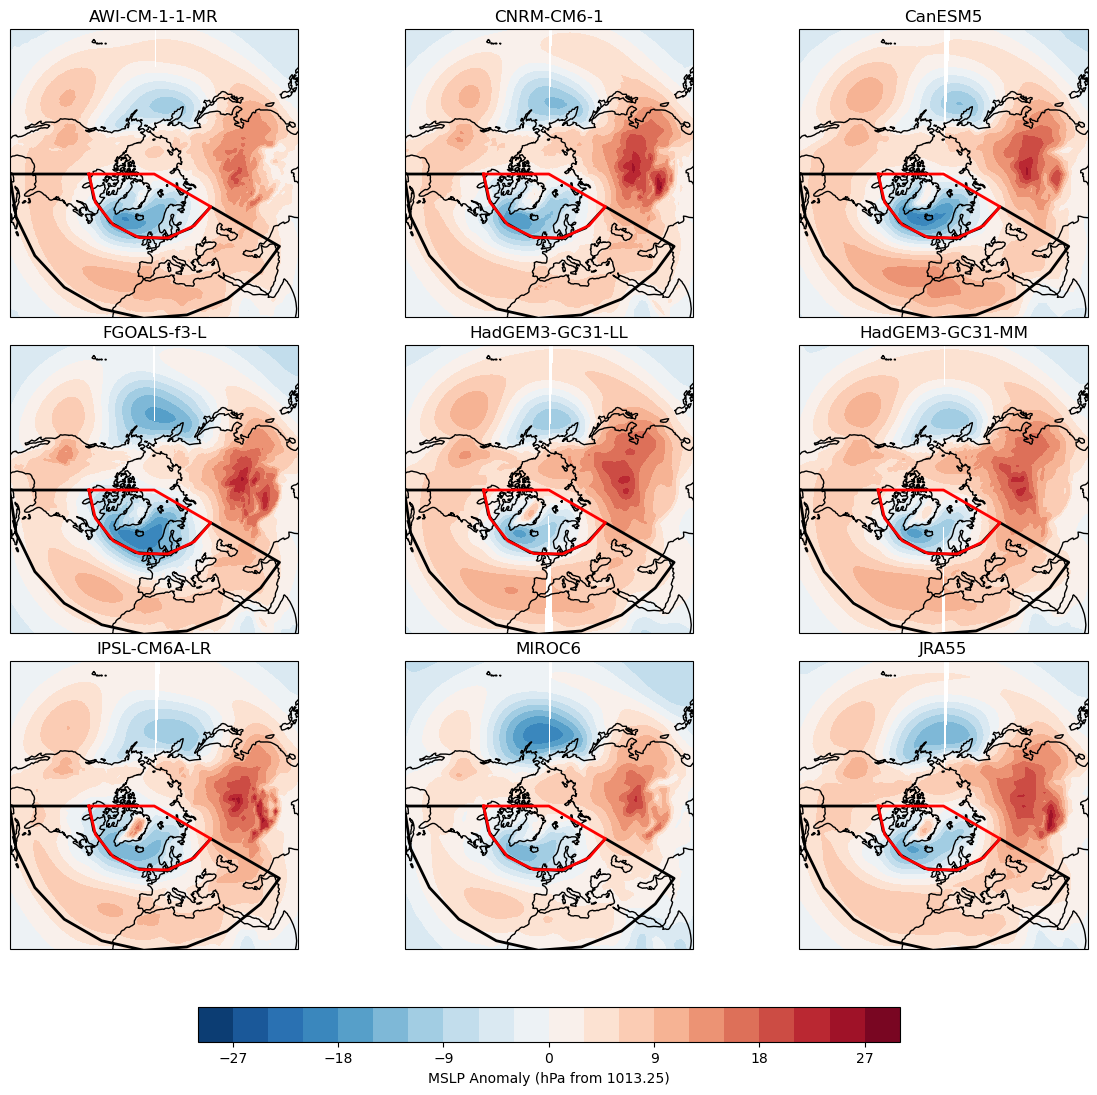

In [6]:
# Define bounding boxes in degrees
lon_min, lon_max = -90, 60  # 90°W to 60°E
southern_lat_min, southern_lat_max = 20, 55
northern_lat_min, northern_lat_max = 55, 90

def add_box(ax, lon_min, lon_max, lat_min, lat_max, **kwargs):
    """Add a rectangular box to the map."""
    lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
    lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), **kwargs)

# Plot
n_models = len(djf)
ncols = 3
nrows = -(-n_models // ncols)  # ceiling division

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows),
                        subplot_kw={"projection": ccrs.NorthPolarStereo()})

axs = axs.flat if n_models > 1 else [axs]

vmax = 30  # adjust if needed
vmin = -vmax

for ax, (model_name, data) in zip(axs, djf.items()):
    # If there's a time dimension, average over time
    if 'time' in data.dims:
        data = data.mean('time')
    if 'ens_ax' in data.dims:
        data = data.mean('ens_ax')

    # Subtract standard pressure
    psl_anom = data.psl - 1013.25

    # Contourf plot of anomaly
    mesh = ax.contourf(data['lon'].values, data['lat'].values, psl_anom.values,
                       transform=ccrs.PlateCarree(), cmap='RdBu_r',
                       vmin=vmin, vmax=vmax, levels=np.linspace(vmin, vmax, 21))
    
    ax.set_title(model_name)
    ax.coastlines()
    ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())

    # Add boxes
    add_box(ax, lon_min, lon_max, southern_lat_min, southern_lat_max, color='black', linewidth=2)
    add_box(ax, lon_min, lon_max, northern_lat_min, northern_lat_max, color='red', linewidth=2)

# Remove unused axes
for ax in axs[n_models:]:
    fig.delaxes(ax)

plt.tight_layout()
cbar = fig.colorbar(mesh, ax=axs[:n_models], orientation='horizontal', shrink=0.6, pad=0.05)
cbar.set_label('MSLP Anomaly (hPa from 1013.25)')
plt.show()


## NAO Index

In [7]:
def calculate_nao_index(psl, lat_name='lat', lon_name='lon'):
    
    # Longitude wrapping if needed
    if psl[lon_name].max() > 180:
        psl = psl.assign_coords({lon_name: (((psl[lon_name] + 180) % 360) - 180)}).sortby(lon_name)

    # Define boxes
    south_box = psl.sel({lat_name: slice(20, 55), lon_name: slice(-90, 60)})
    north_box = psl.sel({lat_name: slice(55, 90), lon_name: slice(-90, 60)})

    # Area-weighted mean (using cos(lat))
    weights_south = np.cos(np.deg2rad(south_box[lat_name]))
    weights_north = np.cos(np.deg2rad(north_box[lat_name]))
    
    # Make sure weights have the right dimensions
    weights_south, _ = xr.broadcast(weights_south, south_box)
    weights_north, _ = xr.broadcast(weights_north, north_box)

    psl_south = (south_box * weights_south).sum(dim=[lat_name, lon_name]) / weights_south.sum(dim=[lat_name, lon_name])
    psl_north = (north_box * weights_north).sum(dim=[lat_name, lon_name]) / weights_north.sum(dim=[lat_name, lon_name])

    # NAO index is the difference
    nao_index = psl_south - psl_north
    return nao_index.load()


nao_indices = {}
for model_name, data in djf.items():
    nao_indices[model_name] = calculate_nao_index(data.psl)

In [8]:
nao_indices['AWI-CM-1-1-MR']

<xarray.DataArray (time: 1, ens_ax: 100)> Size: 800B
array([[13.73403663, 10.15314823, 12.80162698,  8.12176072, 12.72135661,
        13.90426415, 15.40006588, 14.03505622, 11.45963771, 19.68084635,
        19.05946122,  5.98410356,  5.92194093,  8.88243205, 11.42276424,
        14.77042365, 11.49099221, 14.67012885, 14.60347429,  6.90140491,
        15.39734378, 16.53683042,  9.70487816, 14.00148409,  9.43374519,
        17.18201617, 11.05282759, 14.73073185,  9.34604274,  8.38218702,
        10.51897326,  5.67114689, 13.70341378, 12.1413047 , 15.65117853,
        15.73449578,  9.52810078,  6.36009264, 12.92460747,  5.23376129,
        11.43611374, 11.5550878 , 17.7001948 , 10.58440543,  6.45297957,
        14.09526673, 13.94492411, 15.69899771, 19.41390781, 12.99298765,
         4.1518436 , 12.74878149, 13.00224064, 14.66319883,  9.69504043,
        15.89211928, 12.93052737,  7.57323942, 12.51665245, 14.21567503,
        14.41322276, 15.10539425, 14.25826232,  5.81972206,  9.75532912,
         3.25340084,  2.52352978, -0.15787575, 11.14581821, 18.18207058,
         8.67525521, 11.83323014,  8.62128125, 14.2092075 , 14.44249127,
         6.45228225, 15.22526935,  6.83711278,  6.37921696, 10.23718229,
        13.04029676, 14.49870798, 14.21184626,  6.48171696,  7.19248865,
        17.690768  , 11.49074937, 11.47106652, 13.43947178, 13.49178413,
        14.29970857,  5.17393227,  6.54238961, 12.95073542,  9.10598329,
         9.37756065,  9.35597513,  7.45589576,  9.29511048,  8.93159752]])
Coordinates:
  * time     (time) datetime64[ns] 8B 2000-12-01
Dimensions without coordinates: ens_ax

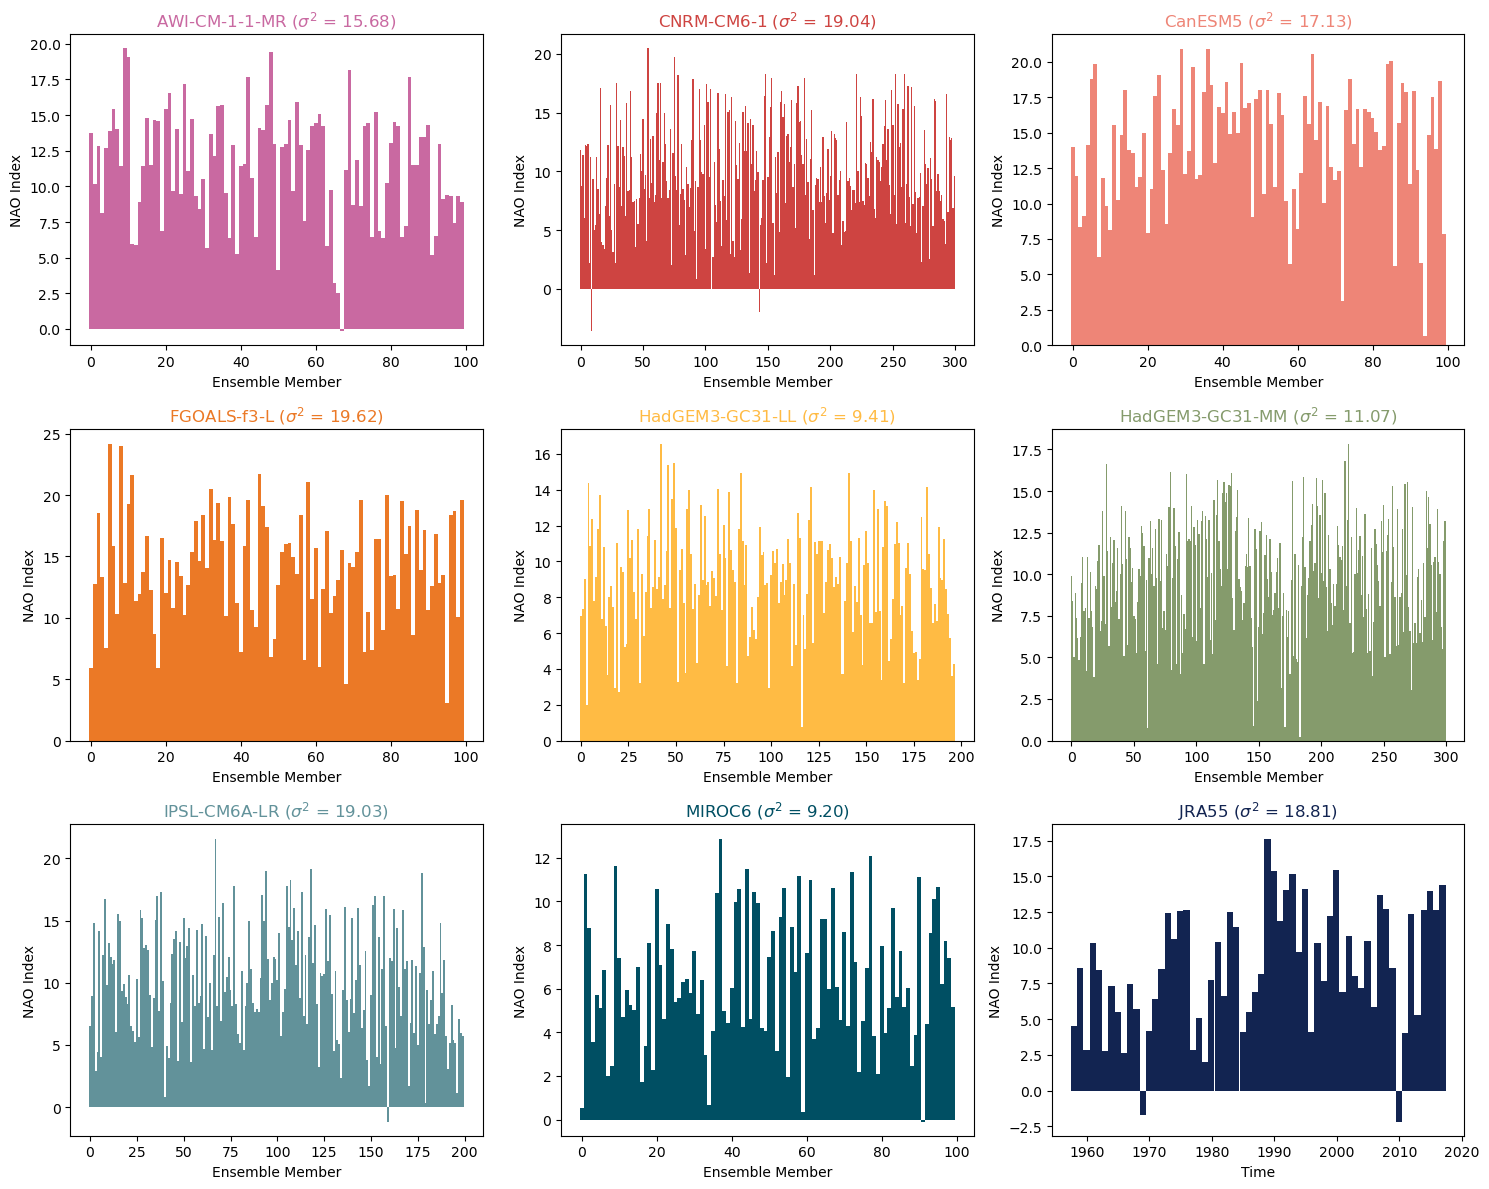

In [9]:
from pypalettes import load_cmap
cmap = load_cmap("Cross")

models = list(nao_indices.keys())
n_models = len(models)

cols = 3
rows_grid = int(np.ceil(n_models / cols))

fig, axs = plt.subplots(rows_grid, cols, figsize=(cols * 5, rows_grid * 4))
axs = axs.flatten()

# Define color palette
color_list = cmap.colors
model_colors = {}

# Assign colors to each model
for i, model in enumerate(models):
    model_colors[model] = color_list[i % len(color_list)]

variance_info = []

for i, model in enumerate(models):
    ax = axs[i]
    nao_data = nao_indices[model]

    
    # X-axis and bar width
    if model == 'JRA55':
        time = nao_data['time']
        width= time[1] - time[0]  # Calculate width based on time intervals
    else:
        nao_data = nao_data.mean('time')
        time = nao_data['ens_ax']
        width = 1

    # Variance
    variance = float(nao_data.var())
    variance_info.append({'model': model, 'variance': np.round(variance, 2)})

    # Bar color: single color per model
    color = model_colors[model]
    
    # Plot
    ax.bar(time, nao_data, color=color, width=width)
    ax.set_xlabel("Time" if model == 'JRA55' else "Ensemble Member")
    ax.set_ylabel("NAO Index")
    ax.set_title(f"{model} ($\\sigma^2$ = {variance:.2f})", color=color)

# Remove unused axes
for ax in axs[len(models):]:
    fig.delaxes(ax)

fig.tight_layout()
plt.show()


## NAO variance vs EFP

In [10]:
df = pd.DataFrame(variance_info)
df

,model,variance
0,AWI-CM-1-1-MR,15.68
1,CNRM-CM6-1,19.04
2,CanESM5,17.13
3,FGOALS-f3-L,19.62
4,HadGEM3-GC31-LL,9.41
5,HadGEM3-GC31-MM,11.07
6,IPSL-CM6A-LR,19.03
7,MIROC6,9.20
8,JRA55,18.81


In [11]:
# Use dict comprehension to split values into separate lookup dicts
efp_nh_map = {model: values[0] for model, values in efp.items()}
efp_sh_map = {model: values[1] for model, values in efp.items()}

# Use pd.Series.map to assign values safely by matching model names
df['efp_nh'] = df['model'].map(efp_nh_map)
df['efp_sh'] = df['model'].map(efp_sh_map)
df 

,model,variance,efp_nh,efp_sh
0,AWI-CM-1-1-MR,15.68,0.2592,0.2557
1,CNRM-CM6-1,19.04,0.2244,0.1944
2,CanESM5,17.13,0.3133,0.3271
3,FGOALS-f3-L,19.62,0.2353,0.1273
4,HadGEM3-GC31-LL,9.41,0.1735,0.1729
5,HadGEM3-GC31-MM,11.07,0.2525,0.1874
6,IPSL-CM6A-LR,19.03,0.2623,0.2015
7,MIROC6,9.20,0.1592,0.2058
8,JRA55,18.81,0.3271,0.1793


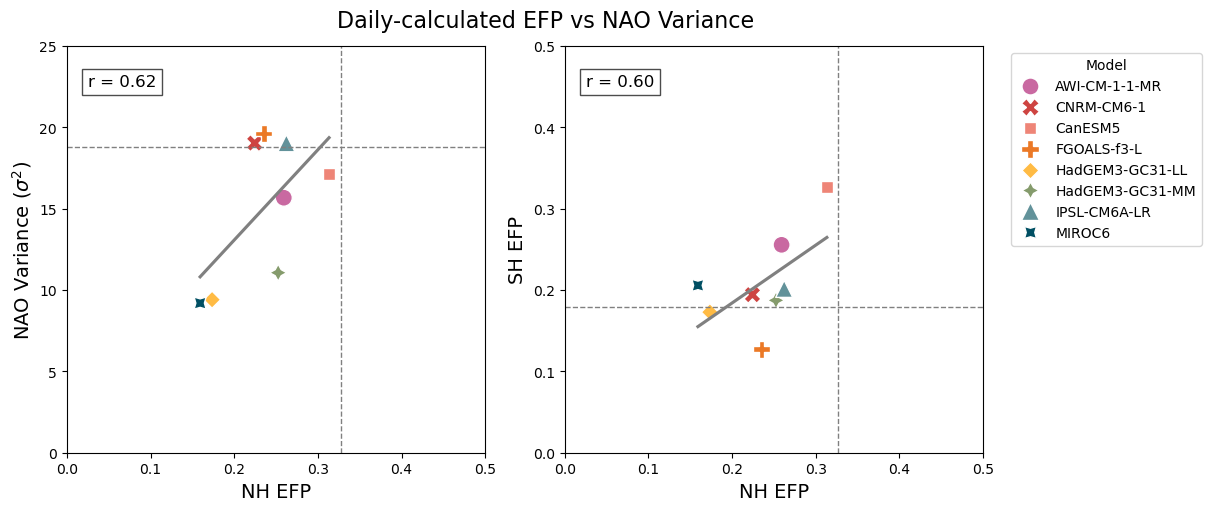

In [12]:
jra = df.loc[df['model'] == 'JRA55'].copy().reset_index(drop=True)
pamip = df.loc[df['model'] != 'JRA55'].copy().reset_index(drop=True)

from pypalettes import load_cmap

# Load colormap and set up palette
cmap = load_cmap("Cross")
models = df['model'].unique()
colors = [cmap(i / (len(models) - 1)) for i in range(len(models))]
palette = dict(zip(models, colors))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot 1: EFP NH vs Variance
sns.regplot(ax=axes[0], data=pamip, x='efp_nh', y='variance', scatter_kws={'color': 'white'}, 
            line_kws={"color": "gray"}, ci=None)
sns.scatterplot(ax=axes[0], data=pamip, x='efp_nh', y='variance', hue='model', style='model', 
                s=150, palette=palette)

r, _ = sp.stats.pearsonr(y=pamip['variance'], x=pamip['efp_nh'])
axes[0].text(.05, .9, f"r = {r:.2f}", transform=axes[0].transAxes, 
             bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

axes[0].set_ylabel('NAO Variance ($\\sigma^2$)', fontsize=14)
axes[0].set_xlabel('NH EFP', fontsize=14)
axes[0].set_xlim(0, 0.5)
axes[0].set_ylim(0, 25)
axes[0].axvline(jra['efp_nh'].values[0], color='gray', linestyle='--', linewidth=1)
axes[0].axhline(jra['variance'].values[0], color='gray', linestyle='--', linewidth=1)
axes[0].legend_.remove()

# Plot 2: EFP SH vs EFP NH
sns.regplot(ax=axes[1], data=pamip, x='efp_nh', y='efp_sh', scatter_kws={'color': 'white'}, 
            line_kws={"color": "gray"}, ci=None)
sns.scatterplot(ax=axes[1], data=pamip, x='efp_nh', y='efp_sh', hue='model', style='model', 
                s=150, palette=palette)

r, _ = sp.stats.pearsonr(x=pamip['efp_sh'], y=pamip['efp_nh'])
axes[1].text(.05, .9, f"r = {r:.2f}", transform=axes[1].transAxes, 
             bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

axes[1].set_ylabel('SH EFP', fontsize=14)
axes[1].set_xlabel('NH EFP', fontsize=14)
axes[1].set_xlim(0, 0.5)
axes[1].set_ylim(0, 0.5)
axes[1].axvline(jra['efp_nh'].values[0], color='gray', linestyle='--', linewidth=1)
axes[1].axhline(jra['efp_sh'].values[0], color='gray', linestyle='--', linewidth=1)

axes[1].legend(bbox_to_anchor=(1.05, 1), title='Model')

fig.suptitle('Daily-calculated EFP vs NAO Variance', fontsize=16, x=0.45)
plt.show()